#Import Liblary

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
# import fiftyone as fo
# import fiftyone.zoo as foz
print(tf.version.VERSION)

2.8.0


# Load Model Inception Resnet & Fiftyone Model

In [2]:
# model_anotasi = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")

In [3]:
model = tf.keras.models.load_model('2-Model-Gray-0.001.h5')

In [4]:
# sdir = 'anotasi/'
# file_name = ''+sdir
# resp = {}
# #buat folder
# if os.path.exists(file_name) == False:
#     os.mkdir(''+sdir)

# dir = "newtest/"
# list_class = os.listdir(dir) 
# total_class = len(list_class)
# for i in range(total_class):

#     folder = ""+sdir+list_class[i]
#     if os.path.exists(folder) == False:
#         os.mkdir(folder)
#     list_data = os.listdir(dir+list_class[i]) 
#     total_data = len(list_data)

#     lokasi_save = folder+'/'+'1.jpg'
#     lokasi_file = dir+list_class[i]+'/'+list_data[0]

#     anotasi = cv2.imread(lokasi_file)
#     height, width, channels = anotasi.shape
#     lokasi_dataset = "newtest/"+list_class[i]+"/"
#     dataset = fo.Dataset.from_images_dir(lokasi_dataset)
#     samples = dataset.take(1)
#     samples.apply_model(model_anotasi, label_field="faster_rcnn", confidence_thresh=0.7,classes=["bird"])

#     sample = dataset.first()
#     bird_count = 0
#     bird_count = len(sample.faster_rcnn.detections)
#     response = []
#     bouding_box = []
#     no_bird = False
#     for j in range(len(sample.faster_rcnn.detections)):
#         # check anotasi kosong
#         if len(sample.faster_rcnn.detections) != 0 :

#             if j<=4:
#                 detection = sample.faster_rcnn.detections[j]
#                 resp = {}
#                 box = {}
#                 # check anotasi burung
#                 if (detection.label=='bird'):
#                     # konvert anotasi ke kordinat
#                     no_bird = True
#                     x, y, w, h = detection.bounding_box
#                     bbox = [x * width, y * height, w * width, h * height]
#                     X = int(bbox[0])
#                     Y = int(bbox[1])
#                     W = int(bbox[2])
#                     H = int(bbox[3])
#                     X = X-20
#                     box["x"] = X
#                     Y = Y-20
#                     box["y"] = Y
#                     W = W+20
#                     box["w"] = W
#                     H = H+20
#                     box["h"] = H
#                     # crop gambar dengan anotasi
#                     cropped_image = anotasi[Y:Y+H, X:X+W]
#                     cropped_image = cv2.resize(cropped_image, (224, 224))
#                     cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
#                     cv2.imwrite("anotasi/"+list_class[i]+"/"+str(j)+'.jpg', cropped_image)
        

# validasi data test

In [5]:
# dir = "anotasi/"
# list_class = os.listdir(dir) 
# total_class = len(list_class)
# for i in range(total_class):
#     list_data = os.listdir(dir+list_class[i]) 
#     total_data_folder = len(list_data)
#     if(total_data_folder<5):
#         for j in range(total_data_folder,5,1):
#             img = np.zeros((224,224,3), dtype=np.uint8)
#             cv2.imwrite("anotasi/"+list_class[i]+"/"+str(j+2)+'.jpg', img)
            

In [6]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [7]:
def datalist (sdir,name):
    catpath=os.path.join(sdir, name)
    filepaths=[]
    labels=[]    
    classlist=os.listdir(catpath)
    for klass in classlist:
        classpath=os.path.join(catpath,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)               
    print('data_frame length: ', len(df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    return df

In [8]:
sdir=r''
#create datalist train 

name = 'anotasi'
test_df= datalist(sdir,name)

data_frame length:  1567


In [9]:
def scalar(img):    
    return img

In [10]:
img_size=(224,224)
working_dir = r''
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
tvgen=ImageDataGenerator(preprocessing_function=scalar)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 1567 validated image filenames belonging to 325 classes.


In [11]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index) 
    tests=len(preds)
    acc= (1-errors/tests) *100
    msg= f'There were {errors} errors in {tests} test cases Model accuracy= {acc: 6.2f} %'
    print_in_color(msg,(0,255,255),(55,65,80))
    
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

In [12]:
subject='BIRDS'
print_code=30 # maximum number of miscallifications to display
preds=model.predict(test_gen) 

In [13]:
def print_metrics(model, dataset_generator):
    score = model.evaluate(test_gen)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

There were 67 errors in 1567 test cases Model accuracy=  95.72 %



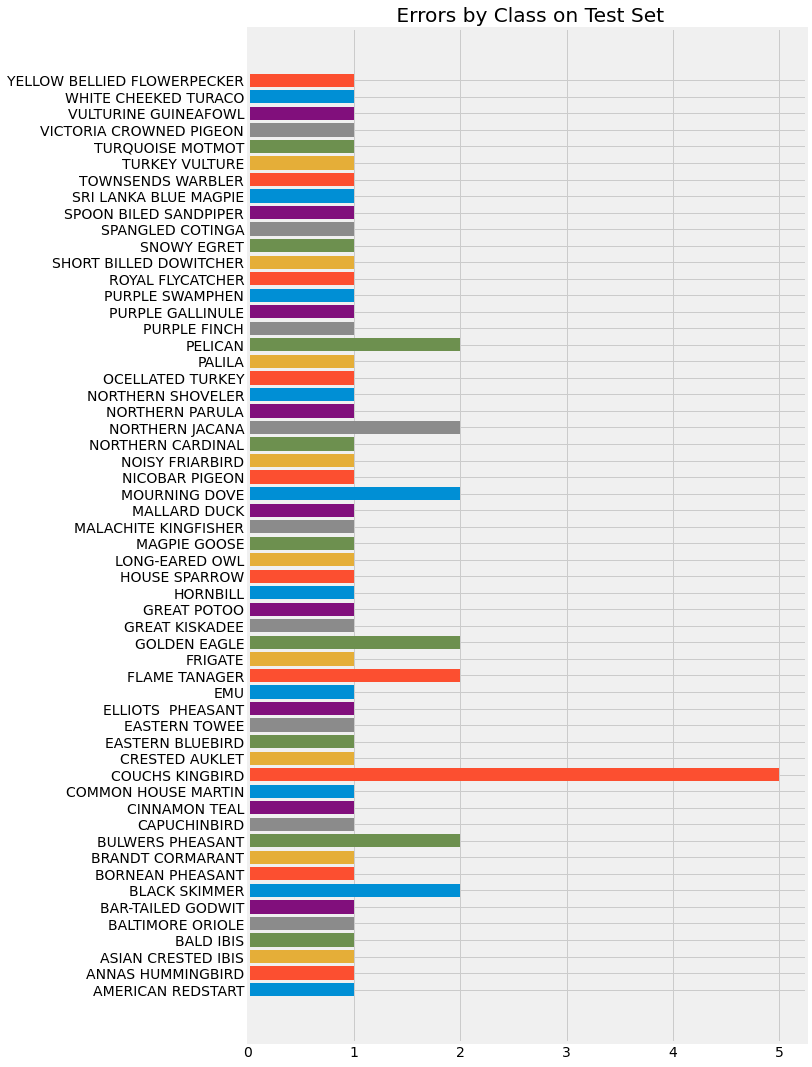

In [14]:
acc=print_info( test_gen, preds, print_code, working_dir, subject ) 

In [15]:
print_metrics(model, test_gen)

1567/1567 [==============================] - 106s 65ms/step - loss: 0.2006 - accuracy: 0.9572
Test loss: 0.200611412525177
Test accuracy: 0.9572431445121765


In [16]:
classes=list(test_gen.class_indices.keys())
y_real = test_gen.classes
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(y_real,y_pred,target_names=classes, digits= 4))

                             precision    recall  f1-score   support

      AFRICAN CROWNED CRANE     1.0000    1.0000    1.0000         5
          AFRICAN FIREFINCH     0.8333    1.0000    0.9091         5
                  ALBATROSS     0.8333    1.0000    0.9091         5
       ALEXANDRINE PARAKEET     0.7143    1.0000    0.8333         5
            AMERICAN AVOCET     1.0000    1.0000    1.0000         5
           AMERICAN BITTERN     1.0000    1.0000    1.0000         5
              AMERICAN COOT     0.5556    1.0000    0.7143         5
         AMERICAN GOLDFINCH     1.0000    1.0000    1.0000         5
           AMERICAN KESTREL     1.0000    1.0000    1.0000         5
             AMERICAN PIPIT     1.0000    1.0000    1.0000         5
          AMERICAN REDSTART     1.0000    0.8000    0.8889         5
                    ANHINGA     1.0000    1.0000    1.0000         5
          ANNAS HUMMINGBIRD     0.8000    0.8000    0.8000         5
                    ANTBIRD     1

c:\Users\Gigabyte\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gigabyte\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gigabyte\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

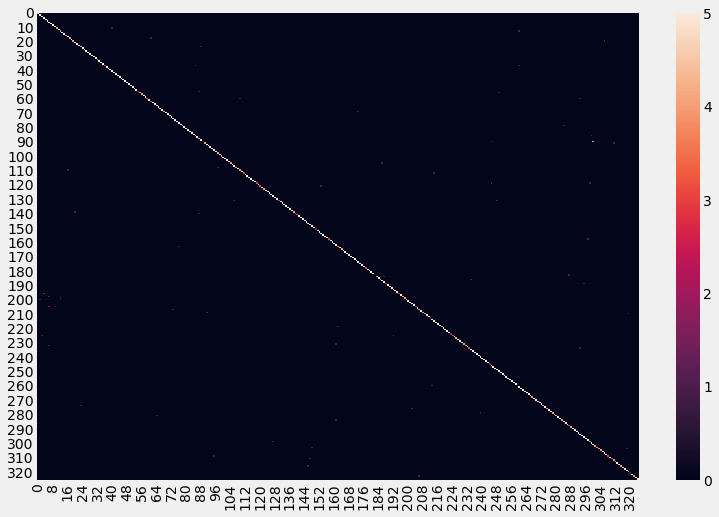

In [17]:
plt.figure(1, figsize=(12,8))
sns.heatmap(confusion_matrix(y_real,y_pred))